# Explore here

In [40]:
#Imports
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import numpy as np
from sklearn.metrics import *
import pandas as pd
from numpy.random import choice, seed
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 

In [23]:
#Loading the pre-processed df 
df = pd.read_csv('/workspaces/JMP1ST-RANDOM-FOREST/src/knn_imputed_diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,165.0,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,35.2,134.2,30.1,0.349,47.0,1.0


As our df is cleaned we can build our Random Forest 

In [24]:
#Splitting the data 

X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Homemade RF class following class method 
class RandomForestBootstrap:

  def __init__(self, n_estimators, random_state, max_depth, min_samples_leaf, max_features, X, y):
    self.n_estimators = n_estimators
    self.random_state = random_state
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_features = max_features
    self.X = X
    self.y = y
    self.estimators = []

  def get_bootstrap_datasets(self):
    #Random seed
    seed(self.random_state)
    #Rows idx
    idxs = [choice(len(self.X), len(self.X), replace=True) for _ in range(self.n_estimators)]
    #Characteristics
    feature_idxs = [choice(self.X.shape[1], self.max_features, replace=False) for _ in range(self.n_estimators)]
    return feature_idxs, [(self.X[idxs[i],:][:,feature_idxs[i]], self.y[idxs[i]]) for i in range(self.n_estimators)]


  def fit(self):
    #Estimators datasets
    feature_idxs, data_sets = self.get_bootstrap_datasets()
    # Para cada estimador realizamos el entrenamiento con su versión del dataset
    for i, data in enumerate(data_sets):
      #Estimator X
      X, y = data
      #Tree training
      arbol = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, random_state=self.random_state).fit(X,y)
      #Saving the estimator
      self.estimators.append((feature_idxs[i], arbol))

  def predict(self, X):
      #Trained models
      predictions = np.vstack([arbol.predict(X[:,idxs]) for idxs, arbol in self.estimators])
      #Common classes
      predicciones = [Counter(predictions[:,i]).most_common(1)[0][0] for i in range(predictions.shape[1])]
      return predicciones


In [ ]:
#Converting train/test sets to NumPy arrays before passing them into the class (Solution from internet)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [27]:
#Training a base line Random Forest

#Simple random forest
rf_simple = RandomForestBootstrap(
    n_estimators=3,
    max_depth=3,
    min_samples_leaf=30,
    max_features=X_train.shape[1] // 2,
    random_state=42,
    X=X_train,
    y=y_train
)
rf_simple.fit()

#Complex random forest
rf_complex = RandomForestBootstrap(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=1,
    max_features=int(X_train.shape[1] * 0.8),
    random_state=42,
    X=X_train,
    y=y_train
)
rf_complex.fit()

In [28]:
#Predictions for simple model
y_pred_train_simple = rf_simple.predict(X_train)
y_pred_test_simple = rf_simple.predict(X_test)

#Predictions for complex model
y_pred_train_complex = rf_complex.predict(X_train)
y_pred_test_complex = rf_complex.predict(X_test)

In [29]:
#Metrics following class method
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    #Training metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    #Test metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    #Differences
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    #Results DataFrame
    metrics_df = pd.DataFrame(
        [
            [train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],
            [test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],
            [diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]
        ],
        columns=['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
        index=['Train', 'Test', 'Difference']
    )

    return metrics_df

In [ ]:
#Simple metrics
get_metrics(y_train, y_test, y_pred_train_simple, y_pred_test_simple)


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.804560,0.698492,0.768516,0.755435,0.649533,0.8875
Test,0.733766,0.585859,0.688519,0.644444,0.537037,0.8400
Difference,0.070794,0.112634,0.079998,0.110990,0.112496,0.0475


In [ ]:
#Complex metrics
get_metrics(y_train, y_test, y_pred_train_complex, y_pred_test_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.00,1.000000,1.000000,1.000000,1.00
Test,0.714286,0.56,0.669259,0.608696,0.518519,0.82
Difference,0.285714,0.44,0.330741,0.391304,0.481481,0.18


The simple random forest model achieved a training accuracy of 80.5% and test accuracy of 73.4%, with a small difference of about 7% between them, indicating good and balanced performance (F1 test: 0.59, specificity test: 0.84). On the other hand, the complex model reached perfect training accuracy (100%) but only 71.4% on the test set, showing a large 28.6% drop that indicates overfitting (F1 test: 0.56, specificity test: 0.82). This indicates that the simpler model, with fewer trees and stricter parameters, is more robust and less prone to overfitting, making it a better choice for predicting diabetes.

Building and analyzing Random Forest with Hyperparameter Tuning

In [32]:
#Hyperparameter grid to test
max_depth_values = [3, 5, 10, 15, 20]
min_samples_leaf_values = [1, 5, 10, 20, 30]

results = []

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        #Building the model
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
        #Train
        rf.fit(X_train, y_train)
        
        #Predict 
        y_pred_test = rf.predict(X_test)
        
        #Calculate accuracy
        acc = accuracy_score(y_test, y_pred_test)
        
        results.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
            'accuracy': acc
        })

In [33]:
#Convert results to DataFrame
results_df = pd.DataFrame(results)

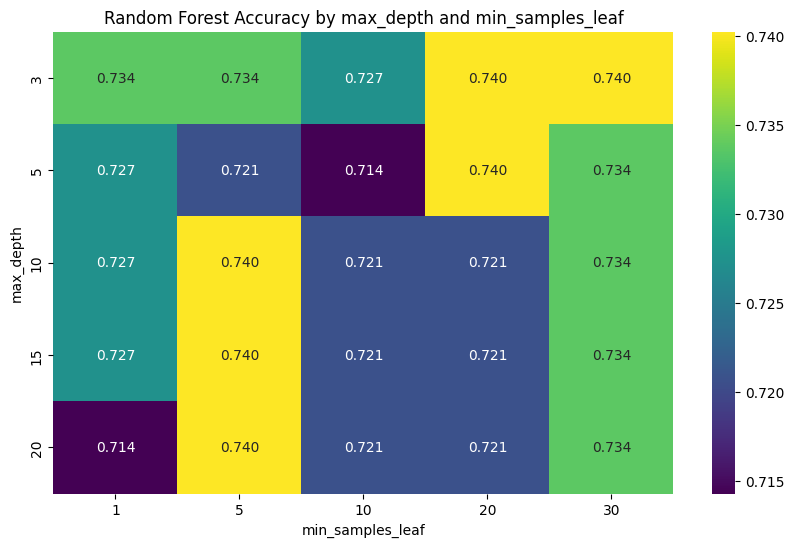

In [ ]:
#Plots

#Accuracy heatmap for different hyperparameter combinations
accuracy_pivot = results_df.pivot(index='max_depth', columns='min_samples_leaf', values='accuracy')

plt.figure(figsize=(10,6))
sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title("Random Forest Accuracy by max_depth and min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.show()

The random forest accuracy analysis shows that moderate tree depths (around 5 to 10) combined with smaller minimum samples per leaf (1 to 10) consistently achieve the highest accuracy of approximately 74%. Increasing tree depth beyond this range or increasing the minimum samples per leaf tends to reduce accuracy slightly, likely due to overfitting or underfitting effects. This confirms that carefully tuning these hyperparameters enriches model diversity and improves predictive performance compared to a single decision treee

Based on the accuracy results, the best model is the one with:

max_depth = 5

min_samples_leaf = 1

In [41]:
#Getting the final model with best hyperparameters
final_rf = RandomForestBootstrap(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=1,
    max_features=int(X_train.shape[1] * 0.8),
    random_state=42,
    X=X_train,
    y=y_train
)
final_rf.fit()

In [43]:
#Saving the model
joblib.dump(final_rf, '/workspaces/JMP1ST-RANDOM-FOREST/models.pkl')

['/workspaces/JMP1ST-RANDOM-FOREST/models.pkl']